In [5]:
import glob,os

import pandas as pd
import deepchem as dc
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw, PyMol, rdFMCS
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
from deepchem import metrics
from IPython.display import Image, display
from rdkit.Chem.Draw import SimilarityMaps
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

E:\Anaconda\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
E:\Anaconda\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
E:\Anaconda\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
E:\Anaconda\Lib\site-packages\requests\__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
E:\Anaconda\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility. Expected 80 from C header, got 88 from PyObject
  return f(*args, **kwds)


# 原理 

可视化模型对分子性质预测的贡献（contributions），即模型对每个原子的贡献值。具体来说，它将测试集中的分子通过已经训练好的模型进行性质预测，并将预测结果与每个原子的贡献值进行比较，然后使用 SimilarityMaps.GetSimilarityMapFromWeights 将贡献值可视化为分子结构上的颜色映射。

“**预测结果与每个原子的贡献值进行比较**”：
```Contrib_i = Molecule - Fragment_i
```
    在计算原子贡献值时，不是真的将分子中的原子移除，而是将该原子的特征向量置为0，然后再用模型对修改后的分子进行性质预测。这样，相当于是将该原子的贡献值从分子的性质预测结果中减去，而不是真的将原子从分子中移除。

['O=C(N(C(C1=C2)=O)C3=CC=C(C=C3)C4(C5=CC=CC=C5C6=C4C=CC=C6)C7=CC=C(C=C7)[*])C1=CC=C2C(C8=CC9=C(C(N(C9=O)[*])=O)C=C8)(C(F)(F)F)C(F)(F)F'] [array([284.0331], dtype=float32)]
[<Figure size 180x180 with 1 Axes>] ==
                                              SMILES  \
0  O=C(N(C(C1=C2)=O)C3=CC=C(C=C3)C4(C5=CC=CC=C5C6...   

  D:\0研究生\research\1聚酰亚胺Tg\0PI\GNN_model-R2=0.86  
0                                     [284.0331]  


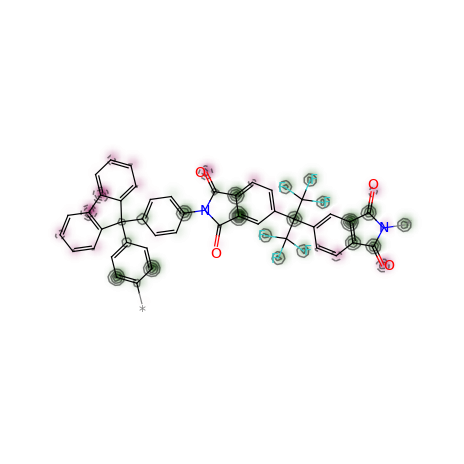

In [17]:
def vis_contribs(mols, df, smi_or_sdf = "smi"):
    # input format of file, which was used to create dataset determines the order of atoms,
    # so we take it into account for correct mapping!
    maps = []
    for i,mol  in enumerate(mols):
        wt = {}
        if smi_or_sdf == "smi":
            for n,atom in enumerate(Chem.rdmolfiles.CanonicalRankAtoms(mol)):
                wt[atom] = df.loc[smiles[i],"Contrib"][n]
        if smi_or_sdf == "sdf":
            # X = mol.GetAtoms()

            # print("atoms",X)
            for n,atom in enumerate(range(mol.GetNumHeavyAtoms())):
                wt[atom] = df.loc[Chem.MolToSmiles(mol),"Contrib"][n]
        maps.append(SimilarityMaps.GetSimilarityMapFromWeights(mol,wt))
    return maps


Restore_MODEL_DIR = 'Path/To/Model'
MODEL_DIR = Restore_MODEL_DIR

# #原子贡献数据集转换
tr = dc.trans.FlatteningTransformer(frag_dataset)
frag_dataset = tr.transform(frag_dataset)

df2 = pd.read_csv(TESTSET_FILE, encoding='utf-8')
smiles = df2["Smiles"].tolist()
mols = [Chem.MolFromSmiles(smile) for smile in smiles]

result ={}

m = dc.models.GraphConvModel(1, mode="regression", model_dir=MODEL_DIR)
m.restore()
pred = m.predict(testset)
pred_frags = m.predict(frag_dataset)

x = testset.ids
y = pred
print(list(x),list(pred))
pred = pd.DataFrame(pred, index=testset.ids, columns=["Molecule"])  # turn to dataframe for convinience
result["SMILES"]=list(x)
result[MODEL_DIR]=list(y)


# fragments
pred_frags = pd.DataFrame(pred_frags, index=frag_dataset.ids, columns=["Fragment"])

# merge 2 dataframes by molecule names
df = pd.merge(pred_frags, pred, right_index=True, left_index=True)
# find contribs
df['Contrib'] = df["Molecule"] - df["Fragment"]


maps = vis_contribs(np.array(mols), df)
for i,map in enumerate(maps):

    map.savefig("original_%s_%s_0.png" %('PI',i), dpi=1000, bbox_inches = 'tight')
    img = Image.open("enhanced_%s_%s_0.png"%('PI',i))

    plt.figure("Image", (5, 5), dpi=1000)  # 图像窗口名称
    plt.imshow(img)
    plt.axis('off')  # 关掉坐标轴为 off
    f = plt.gcf()
    plt.figtext(0.2, 0.9, "PI atom contribution map", fontsize=15)
    plt.figtext(0.1, 0.8, "( Note: red indicates inhibition of the part of the property,", fontsize=8)
    plt.figtext(0.1, 0.75, "green indicates contribution of the part of the property. )", fontsize=8)
    plt.figtext(0.1, 0.2, "Property type: %s"%('Tg'), fontsize=8)
    plt.figtext(0.1, 0.15, "smiles: %s"%(smiles[i]), fontsize=8)
    plt.savefig("original_%s_%s.png"%('PI',i), dpi=1000)
    plt.close()

print(maps,"==")

pred_re = pd.DataFrame(result)  # turn to dataframe for convinience
print(pred_re)